In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import copy

import torch.optim as optim

In [2]:
def loss_func(pred, y): return (pred-y)**2

In [3]:
def train(index = 0, num_global_iters = 50, num_local_iters = 10, local_iter_thres = None,  lr = 0.1):
    server_model = Model()
    client_models = [copy.deepcopy(server_model) for i in range(2)]

    memory = list()
    memory.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy() * server_model.scale.data.detach().cpu().numpy()))
    memory_w = list()
    memory_w.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()))
    memory_b = list()
    memory_b.append(copy.deepcopy(server_model.scale.data.detach().cpu().numpy()))
    memory_loss = list()
    for epoch in range(num_global_iters):  
        
        client_models = [copy.deepcopy(server_model) for i in range(2)]
        optimizers = [optim.SGD(client_models[idx].parameters(), lr=lr) for idx in range(2)]
        
        for client_idx in range(2):
            model, optimizer = client_models[client_idx], optimizers[client_idx]
            X, Y = Data[client_idx]
            for local_iter in range(num_local_iters):
                
                if local_iter_thres == None: model.scale.requires_grad = True
                elif local_iter < local_iter_thres: model.scale.requires_grad = False
                else: model.scale.requires_grad = True
                                
                pred = model(X)
                loss = loss_func(pred, Y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                if local_iter_thres == None: pass
                # elif local_iter < local_iter_thres: 
                #     if (epoch+1) % 10 == 0: print(epoch, np.round(loss.item(), 3))
                
        # if (epoch+1) % 10 == 0: print(epoch, np.round(loss.item(), 3))

        with torch.no_grad():
            server_model.weight.data.copy_(copy.deepcopy((client_models[0].weight.data + client_models[1].weight.data)/2))
            server_model.scale.data.copy_(copy.deepcopy((client_models[0].scale.data + client_models[1].scale.data)/2))
            memory.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy() * server_model.scale.data.detach().cpu().numpy()))
            memory_w.append(copy.deepcopy(server_model.weight.data.detach().cpu().numpy()))
            memory_b.append(copy.deepcopy(server_model.scale.data.detach().cpu().numpy()))
            loss = 0
            for client_idx in range(2):
                X, Y = Data[client_idx]
                pred = server_model(X)
                loss += loss_func(pred, Y).item() / 2
            memory_loss.append(loss)
    memory = np.array(memory)
    memory_loss = np.array(memory_loss)
    memory_w = np.array(memory_w)
    return memory, memory_loss, memory_w, memory_b

In [16]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.weight = torch.nn.Parameter(torch.Tensor([2, 0.5]), requires_grad=True)
        self.scale = torch.nn.Parameter(torch.Tensor([1]), requires_grad=True)
    def forward(self, x): return x @ self.weight * self.scale
    
Data = [[torch.Tensor([1, 0]), torch.Tensor([0.25])], [torch.Tensor([0, 1]), torch.Tensor([4])]]

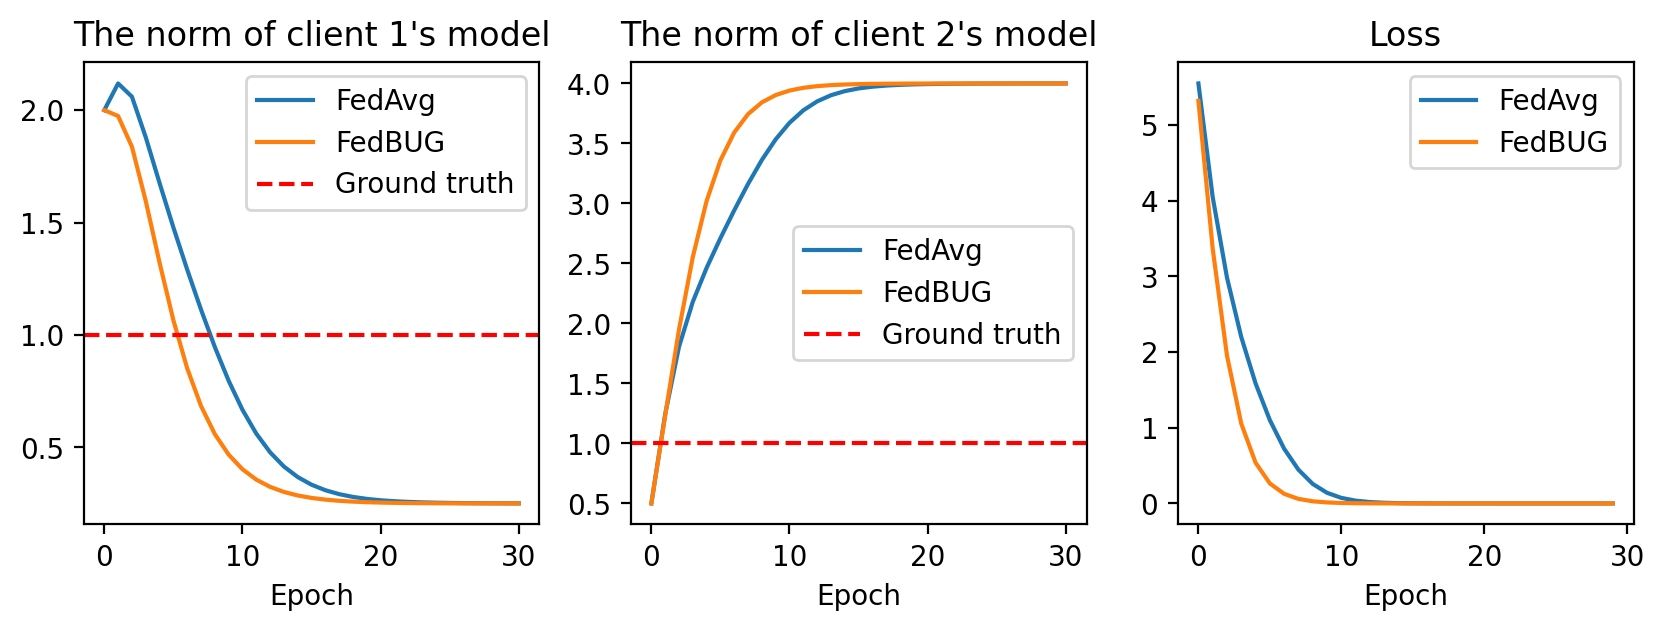

In [17]:
lr = 0.01
num_global_iters = 30
num_local_iters = 20
local_iter_thres = 10
memory, memory_loss, memory_w, memory_b = train(index = 0, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = None,  lr = lr)
memory2, memory_loss2, memory_w2, memory_b2 = train(index = 0, num_global_iters = num_global_iters, num_local_iters = num_local_iters, local_iter_thres = local_iter_thres,  lr = lr)

fig, axes = plt.subplots(1,3,figsize=(10,3),dpi=200)
ax = axes[0]
ax.plot(memory[:,0], label="FedAvg"), ax.plot(memory2[:,0], label="FedBUG")
ax.axhline(1, color='r', linestyle='--', label="Ground truth")
ax.set_title("The norm of client 1's model")
ax = axes[1]
ax.plot(memory[:,1], label="FedAvg"), ax.plot(memory2[:,1], label="FedBUG")
ax.axhline(1, color='r', linestyle='--', label="Ground truth")
ax.set_title("The norm of client 2's model")
ax = axes[2]
ax.plot(memory_loss, label="FedAvg"), ax.plot(memory_loss2, label="FedBUG")
ax.set_title("Loss")

for ax in axes.flatten():
    ax.set_xlabel("Epoch")
    ax.legend()

Text(0.5, 1.0, 'b')

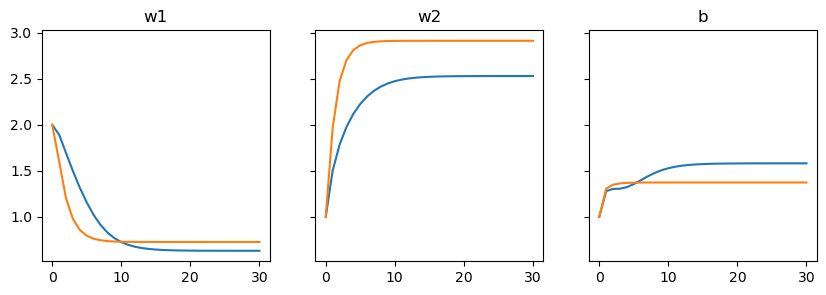

In [6]:
fig, axes = plt.subplots(1,3,figsize=(10,3), dpi=100, sharey=True)
ax = axes[0]
ax.plot(memory_w[:,0], label="FedAvg"), ax.plot(memory_w2[:,0], label="FedBUG")
# ax.axhline(1, color='r', linestyle='--', label="Ground truth")
ax.set_title("w1")
ax = axes[1]
ax.plot(memory_w[:,1], label="FedAvg"), ax.plot(memory_w2[:,1], label="FedBUG")
# ax.axhline(1, color='r', linestyle='--', label="Ground truth")
ax.set_title("w2")
ax = axes[2]
ax.plot(memory_b[:], label="FedAvg"), ax.plot(memory_b2[:], label="FedBUG")
# ax.axhline(1, color='r', linestyle='--', label="Ground truth")
ax.set_title("b")

In [7]:
        memory_b2

[array([1.], dtype=float32),
 array([1.307164], dtype=float32),
 array([1.3495004], dtype=float32),
 array([1.3636549], dtype=float32),
 array([1.369352], dtype=float32),
 array([1.371777], dtype=float32),
 array([1.3728328], dtype=float32),
 array([1.3732982], dtype=float32),
 array([1.3735051], dtype=float32),
 array([1.3735979], dtype=float32),
 array([1.3736397], dtype=float32),
 array([1.3736587], dtype=float32),
 array([1.3736674], dtype=float32),
 array([1.3736717], dtype=float32),
 array([1.3736737], dtype=float32),
 array([1.3736746], dtype=float32),
 array([1.3736748], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 array([1.3736749], dtype=float32),
 a